# 3c. Predict bed counts without using patient snapshots

There are situations where we might want to predict bed count distributions without having details of the patients, for example when predicting the number of beds needed for incoming patients such as:

* Patients yet-to-arrive to the Emergency Department, who will need a bed within a prediction window
* Emergency patients who arrive via other routes than the ED, and become inpatients (such as emergency transfers from other hospitals)
* Elective admissions of patients. Planned elective admissions are recorded on a 'To Come In' (TCI) list by patient number. In data, the hospital visit (known as an encounter) for the elective procedure begins at the moment a patient arrives, but may not be recorded in data prior to that point. In a simple case without making use of any data on TCI lists, we might want to predict bed requirements for such patients based on past patterns of such arrivals between a prediction time (eg 12:00) and the end of a prediction window (eg 8 hours later).  

For these situations, we can use `patientflow` to learn patterns from past data, and use these to predict a bed count distribution at the aggregate level.

In this notebook, I'll use the example of predicting the number of beds needed for patients yet to arrive to the Emergency Department who will need a bed within a prediction window. I'll show three approaches: 

* a Poisson model trained on past arrival rates of patients who both arrived and were admitted within a prediction window
* a weighted Poisson model using an empirical survival curve; arrival rates of patients who were admitted (at some point), are weighted by their probability of being admitted within a prediction window, calculated from a survival curve learned form past data
* a weighted Poisson model using an aspirational approach; instead of using a survival curve learned form past data, it is assumed that the ED is meeting 4-hour targets for time to admission. 

I demonstrate both predictions for whole cohorts of patients, and predictions by specialty. 

In [109]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create fake arrival times

I will generate some fake data on patients in an Emergency Department (ED) using the same method as in previous notebooks. This time, I only need patients who were admitted after the ED visit. 

In [110]:
from patientflow.generate import create_fake_finished_visits
visits_df, _, _ = create_fake_finished_visits('2023-01-01', '2023-04-01', mean_patients_per_day=50, admitted_only=True)
visits_df.head()

,patient_id,visit_number,arrival_datetime,departure_datetime,age,is_admitted,specialty
0,3031,33,2023-01-01 06:12:03,2023-01-01 15:51:03,29,1,medical
1,8829,15,2023-01-01 06:55:24,2023-01-01 21:28:24,34,1,paediatric
2,10479,27,2023-01-01 07:53:54,2023-01-01 11:56:54,61,1,medical
3,10856,8,2023-01-01 08:02:10,2023-01-01 13:16:10,31,1,medical
4,6011,43,2023-01-01 10:05:20,2023-01-01 20:16:20,40,1,medical


I'll rename the `departure_datetime` column to `admitted_to_ward_datetime` since all admitted patients depart to a ward.

Note - if you follow my approach using your own data, make sure you start with a dataset of arrival and admitted-to-ward times that has only one row per visit. Do not use your snapshot dataset for this, if it includes multiple rows per visit. 

In [111]:
import pandas as pd

inpatient_arrivals = visits_df.rename(columns = {'departure_datetime': 'admitted_to_ward_datetime'}).drop(columns = 'is_admitted')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'])

I will generate an array of dates covered by the data I've loaded. I'm calling these `snapshot_dates` for consistency.

In [112]:
from datetime import datetime, time, timedelta, date

# Create date range
snapshot_dates = []
start_date = date(2023, 1, 1)
end_date = date(2023, 4, 1)

current_date = start_date
while current_date < end_date:
    snapshot_dates.append(current_date)
    current_date += timedelta(days=1)

print('First ten snapshot dates')
snapshot_dates[0:10]

First ten snapshot dates


[datetime.date(2023, 1, 1),
 datetime.date(2023, 1, 2),
 datetime.date(2023, 1, 3),
 datetime.date(2023, 1, 4),
 datetime.date(2023, 1, 5),
 datetime.date(2023, 1, 6),
 datetime.date(2023, 1, 7),
 datetime.date(2023, 1, 8),
 datetime.date(2023, 1, 9),
 datetime.date(2023, 1, 10)]

## Predicting future arrivals, with model trained on past data. 

When predicting how many patients will arrive after a prediction time, and be admitted before the end of a prediction window, we need some way to decide how long it takes admitted patients to be processed by the ED. 

The first two approaches, shown in this section, use past data to determine how long a patient will be in the ED before admission. 

* A Poisson model based on counts of patients who arrived and were admitted within in a prediction window (eg arrived after 06:00 and were admitted before 14:00) during the training set period
* A survival curve based on empirical data from the training set period

As in previous notebooks, I'll apply a temporal split to the data. 

In [113]:
from datetime import date   
from patientflow.prepare import create_temporal_splits

# set the temporal split
start_training_set = date(2023, 1, 1) 
start_validation_set = date(2023, 2, 15) # 6 week training set 
start_test_set = date(2023, 3, 1) # 2 week validation set 
end_test_set = date(2023, 4, 1) # 1 month test set

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime", # states which column contains the date to use when making the splits 

)

Split sizes: [2214, 710, 1584]



### Approach 1 using past data: Poisson model trained on past arrival rates of patients who both arrived and were admitted within a prediction window

The function below generates counts by snapshot date of patients who arrived after the prediction time and were admitted before the end of the prediction window. 

After applying the function, the count data is shown below.

In [114]:
from patientflow.calculate.arrival_rates import count_yet_to_arrive

prediction_times = [(6,0), (9,30), (12, 0), (15,30), (22,0)] 

yet_to_arrive_counts = count_yet_to_arrive(inpatient_arrivals, 
                                           snapshot_dates, 
                                           prediction_times, 
                                           prediction_window_hours=8)
yet_to_arrive_counts.head()

,snapshot_date,prediction_time,count
0,2023-01-01,"(6, 0)",2
1,2023-01-01,"(9, 30)",1
2,2023-01-01,"(12, 0)",6
3,2023-01-01,"(15, 30)",3
4,2023-01-01,"(22, 0)",1


Here I use the mean daily count as the mean of a Poisson distribution. 

In [115]:
from scipy import stats
poisson_mean = yet_to_arrive_counts[yet_to_arrive_counts['prediction_time'] == (12, 0)]['count'].mean()
poisson_model = stats.poisson(poisson_mean)

I use the Poisson model to predict a bed count distribution for the patients yet-to-arrive. 


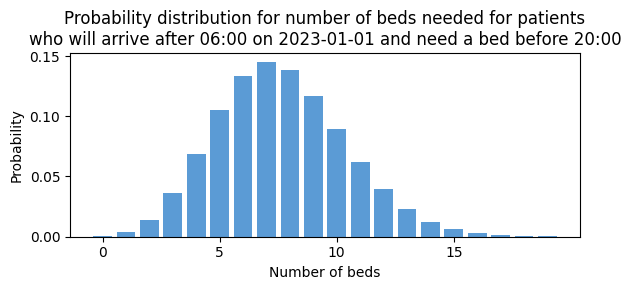

In [116]:
prob_dist_data = [poisson_model.pmf(k) for k in range(20)]

from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed for patients'
    f'\nwho will arrive after {format_prediction_time(prediction_times[0])} on {snapshot_dates[0]} and need a bed before 20:00'
)
prob_dist_plot(prob_dist_data, title,  
    include_titles=True, truncate_at_beds=40)

### Approach 2: Using an empirical survival curve

Another approach is to learn from past data about how long it takes patients to be admitted. To illustrate this, the `plot_admission_time_survival_curve` function will take a dataset of start and end times, and draw a survival curve. 

(Note - survival curves are often used for time to mortality or an adverse event; here 'survival' here means how long the patient remained in the ED prior to admission.)

In the fake data I'm using here, I've deliberately set the mean length of stay to be longer than 4 hours, to illustrate the differences between learning from the past data and (later in the notebook) taking an aspirational approach and assuming the ED meets its 4-hour targets. 

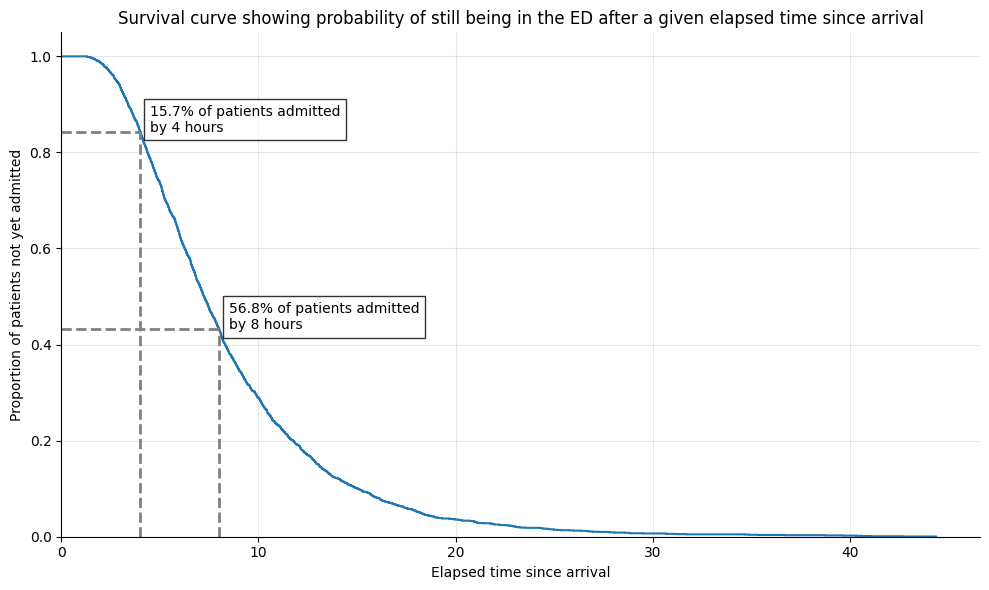

In [117]:
from patientflow.viz.survival_curves import plot_admission_time_survival_curve
title = 'Survival curve showing probability of still being in the ED after a given elapsed time since arrival'
survival_df = plot_admission_time_survival_curve(train_visits, 
                                   start_time_col="arrival_datetime",
                                   end_time_col="admitted_to_ward_datetime",
                                   title=title,
                                   ylabel='Proportion of patients not yet admitted',
                                   xlabel='Elapsed time since arrival',
                                   target_hours=[4, 8],
                                   annotation_string="{:.1%} of patients admitted\nby {:.0f} hours",
                                   return_df=True
)

The function has an option to return the survival curve. 

In [118]:
survival_df.head()

,time_hours,survival_probability,event_probability
0,0.000000,1.000000,0.000000
1,1.283333,0.999548,0.000452
2,1.333333,0.999097,0.000903
3,1.350000,0.998645,0.001355
4,1.400000,0.998193,0.001807


From the curve, we can read the probability of still being in the ED seven hours after arrival. The probability of being admitted within seven hours is one minus this number. 

In [119]:
from patientflow.calculate.admission_in_prediction_window import get_survival_probability
print(f'Probability of still being in the ED seven hours after arrival: {get_survival_probability(survival_df, 7):.2f}')
print(f'Probability of being admitted within seven hours of arrival: {1-get_survival_probability(survival_df, 7):.2f}')


Probability of still being in the ED seven hours after arrival: 0.52
Probability of being admitted within seven hours of arrival: 0.48


If I'm making a prediction at 12:00 for number of admissions by 20:00, I could divide that 8-hour window into 8 slices of one hour, calculate a mean arrival rate for each hour, and use the survival curve to get the probability of the patients who arrive in each hour being admitted by the end of the prediction window.

First I calculate the arrival rate for a one hour slice: 

In [120]:
num_days_in_training_data = (start_validation_set - start_training_set).days
print(f'Number of days in training data: {num_days_in_training_data}')

print(f'Number of admitted patients arriving between 19:00 and 20:00 in training data: {len(train_visits[(train_visits.arrival_datetime.dt.hour == 19) ])}')
print(f'Average number of admitted patients arriving between 19:00 and 20:00 in training data: {(len(train_visits[(train_visits.arrival_datetime.dt.hour == 19) ])/num_days_in_training_data):.2f}')

Number of days in training data: 45
Number of admitted patients arriving between 19:00 and 20:00 in training data: 50
Average number of admitted patients arriving between 19:00 and 20:00 in training data: 1.11


The arrival rate can be multiplied by the probability of admission within the prediction window and used as a weighted mean in a Poisson distribution for each hour. The eight Poisson distributions (one for each hour) can then be convolved into a single distribution. This is shown below. 

(As noted above this may seem complicated. I show it because a similar approach informs the aspirational approach that follows.)

In [121]:
from scipy import stats
import numpy as np

from patientflow.calculate.admission_in_prediction_window import get_survival_probability

# Initialize arrays to store probabilities and rates
hours = range(12, 20)
probabilities = []
rates = []

# Calculate probabilities and rates for each hour
for _hour in hours:
    probability_of_admission = 1-get_survival_probability(survival_df, 20-_hour)
    arrival_rate = len(train_visits[(train_visits.arrival_datetime.dt.hour == _hour)])/num_days_in_training_data
    probabilities.append(probability_of_admission)
    rates.append(arrival_rate)

# Create individual Poisson distributions
poisson_dists = [stats.poisson(r*p) for r, p in zip(rates, probabilities)]

# Get PMF for each distribution 
max_value = 20  
x = np.arange(max_value)
pmfs = [dist.pmf(x) for dist in poisson_dists]

# Convolve all distributions together
combined_pmf = pmfs[0]
for pmf in pmfs[1:]:
    combined_pmf = np.convolve(combined_pmf, pmf)

# Create final distribution
combined_dist = stats.rv_discrete(values=(range(len(combined_pmf)), combined_pmf))


The result is a very similar distribution to that calculated by the more simple approach above. 

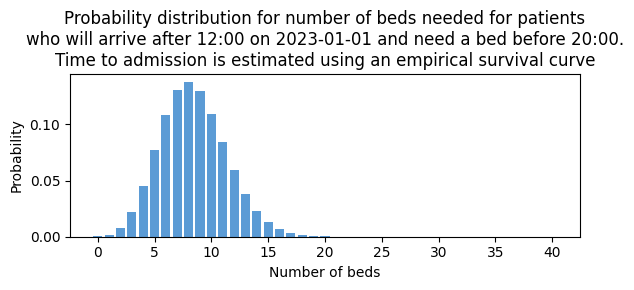

In [122]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed for patients'
    f'\nwho will arrive after {format_prediction_time((12,0))} on {snapshot_dates[0]} and need a bed before 20:00.'
    f'\nTime to admission is estimated using an empirical survival curve'
)
prob_dist_plot(combined_dist, title,  
    include_titles=True, truncate_at_beds=40)

### Using the `EmpiricalSurvivalPredictor` class

A custom class `EmpiricalSurvivalPredictor` has been created, for this purpose, that follows the same logic as the code snippet above. 

A survival curve is generated from the training data, and used determine the probability of admission before the end of the prediction window, for a patient who arrives at a particular moment in the window.

To get a distribution for the number of patients arriving and being admitted within the prediction window, the window (let's say it's 8 hours from now) is divided into discrete segments of time of some length defined by the `yta_time_interval` parameter (let's say this is 15 min), giving us 32 segments of the 8 hour window. For each segment an arrival rate of patients in that segement is calculated. The arrival rate is multiplied by the probability of being admitted by the end of the window, given the time of arrival, to generate a weighted Poisson mean for each segment. The 32 Poisson distributions for each segment are combined to give a probability distribution for the total number of beds needed. 

I demonstrate how you fit the EmpiricalSurvivalPredictor below. 

Note: we treat time as discrete, rather than continuous to make calculations easier. 

In [126]:
from patientflow.predictors.weighted_poisson_predictor import EmpiricalSurvivalPredictor

train_visits_copy = train_visits.copy(deep=True)

yta_model_empirical =  EmpiricalSurvivalPredictor(verbose=True)
num_days = (start_validation_set - start_training_set).days

# the arrival_datetime column needs to be set as the index of the dataframe
if 'arrival_datetime' in train_visits_copy.columns:
    train_visits_copy.set_index('arrival_datetime', inplace=True)

yta_model_empirical.fit(train_visits_copy, 
                        prediction_window=timedelta(hours=8), 
                        yta_time_interval=timedelta(minutes=15), 
                        prediction_times=prediction_times, 
                        num_days=num_days,
                        start_time_col='arrival_datetime',
                        end_time_col='admitted_to_ward_datetime')

Calculating time-varying arrival rates for data provided, which spans 45 unique dates
Weighted Poisson Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 8:00:00 after the time of prediction
and time interval of 0:15:00 within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method
EmpiricalSurvivalPredictor has been fitted with survival curve containing 881 time points


EmpiricalSurvivalPredictor(filters={}, verbose=True)

The survival curve that was calculated from the training set is saved with the object returned

In [127]:
yta_model_empirical.survival_df

,time_hours,survival_probability,event_probability
0,0.000000,1.000000,0.000000
1,1.283333,0.999548,0.000452
2,1.333333,0.999097,0.000903
3,1.350000,0.998645,0.001355
4,1.400000,0.998193,0.001807
...,...,...,...
876,40.333333,0.001807,0.998193
877,40.650000,0.001355,0.998645
878,41.050000,0.000903,0.999097
879,42.666667,0.000452,0.999548


In [128]:
arrival_rates_by_time_interval = yta_model_empirical.weights['unfiltered'][(12,0)]['arrival_rates']
print(
    f'The calculated arrival rates for the first 10 discrete time intervals '
    f'for the 12:00 prediction time are: {[round(v, 3) for v in arrival_rates_by_time_interval[0:10]]}')

The calculated arrival rates for the first 10 discrete time intervals for the 12:00 prediction time are: [1.289, 1.067, 1.356, 1.2, 1.289, 1.356, 1.2, 1.178, 0.933, 0.889]


In [129]:
prediction_context = {
    'unfiltered': {
        'prediction_time': tuple([12,0])
    }
}
weighted_poisson_empirical = yta_model_empirical.predict(prediction_context)


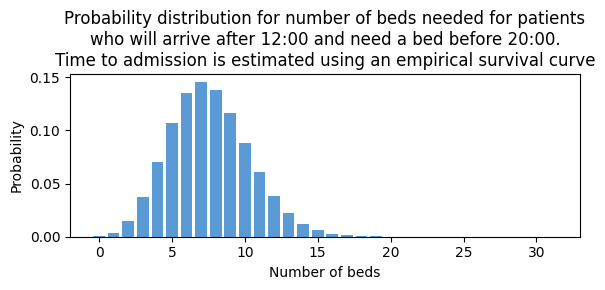

In [130]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed for patients'
    f'\nwho will arrive after {format_prediction_time((12,0))} and need a bed before 20:00.'
    f'\nTime to admission is estimated using an empirical survival curve'
)
prob_dist_plot(weighted_poisson_empirical['unfiltered'], title,  
    include_titles=True, truncate_at_beds=40)

It is also possible to generate predictions by specialty, by passing a dictionary comprised of the required subgroups (the key) and a nested dictionary (the value) specifying how to identify them, with a column name (the nested key) and the values to filter from that column. 

In [132]:
from patientflow.predictors.weighted_poisson_predictor import EmpiricalSurvivalPredictor

train_visits_copy = train_visits.copy(deep=True)
num_days = (start_validation_set - start_training_set).days
if 'arrival_datetime' in train_visits_copy.columns:
    train_visits_copy.set_index('arrival_datetime', inplace=True)
    
specialty_filters = filters={
    'medical': {'specialty': 'medical'},
    'surgical': {'specialty': 'surgical'},
    'haem/onc': {'specialty': 'haem/onc'},
    'paediatric': {'specialty': 'paediatric'}
    }
yta_model_by_spec_empirical =  EmpiricalSurvivalPredictor(filters = specialty_filters, verbose=True)

yta_model_by_spec_empirical.fit(train_visits_copy, 
                        prediction_window=timedelta(hours=8), 
                        yta_time_interval=timedelta(minutes=15), 
                        prediction_times=prediction_times, 
                        num_days=num_days,
                        start_time_col='arrival_datetime',
                        end_time_col='admitted_to_ward_datetime')

Calculating time-varying arrival rates for data provided, which spans 45 unique dates
Calculating time-varying arrival rates for data provided, which spans 45 unique dates
Calculating time-varying arrival rates for data provided, which spans 45 unique dates
Calculating time-varying arrival rates for data provided, which spans 45 unique dates
Weighted Poisson Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 8:00:00 after the time of prediction
and time interval of 0:15:00 within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method
EmpiricalSurvivalPredictor has been fitted with survival curve containing 881 time points


EmpiricalSurvivalPredictor(filters={'haem/onc': {'specialty': 'haem/onc'},
                                    'medical': {'specialty': 'medical'},
                                    'paediatric': {'specialty': 'paediatric'},
                                    'surgical': {'specialty': 'surgical'}},
                           verbose=True)

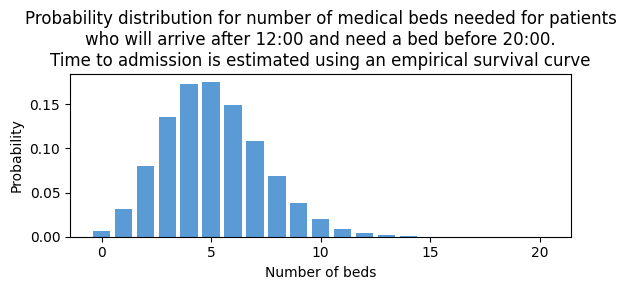

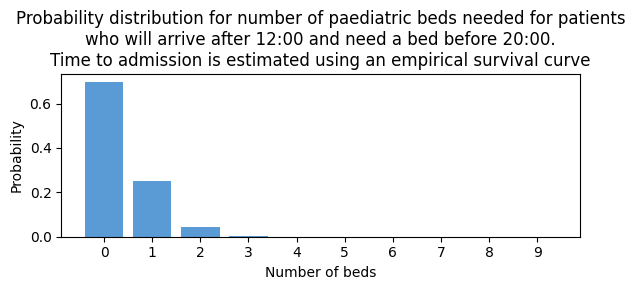

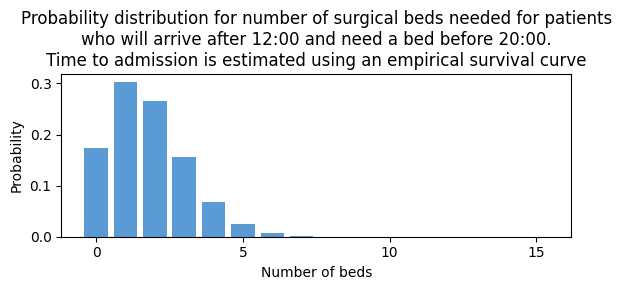

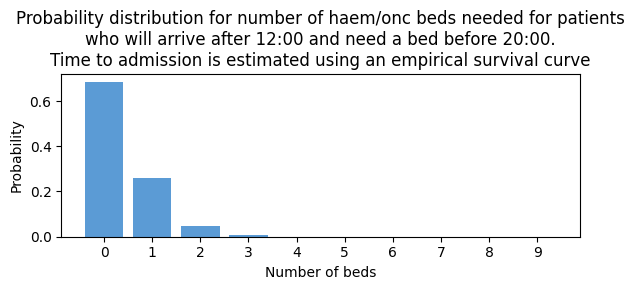

In [133]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time

for specialty in train_visits.specialty.unique():
    prediction_context = {
        specialty: {
            'prediction_time': tuple([12,0])
        }
}
    weighted_poisson_empirical = yta_model_by_spec_empirical.predict(prediction_context)


    title = (
        f'Probability distribution for number of {specialty} beds needed for patients'
        f'\nwho will arrive after {format_prediction_time((12,0))} and need a bed before 20:00.'
        f'\nTime to admission is estimated using an empirical survival curve'
    )
    prob_dist_plot(weighted_poisson_empirical[specialty], title,  
        include_titles=True, truncate_at_beds=20)

## Train a weighted Poisson model using an aspirational approach

The model above has learned the rates of arrivals of patients who are later admitted within a prediction window from past data. 

A problem with this approach is that rates are learned from periods of poor performance. Currently, in England Emergency Departments have a target of processing all patients within four hours of their arrival time. However, EDs across the country have not hit targets since the end of the Covid pandemic.

The poor performance is illustrated by the chart below, which shows how performance within Emergency Departments (also known as Accident & Emergency Departments, or A&E) has deteriorated over time. The chart is based on [NHS England data](https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/) on A&E Attendances and Emergency Admissions, and was copied from the [King's Fund website](https://www.kingsfund.org.uk/insight-and-analysis/data-and-charts/accident-emergency-waiting-times) on 9 June 2025.

Performance is worse for Type 1 A&E attendances; Type 1 refers to patients attending what are considered major emergency departments in hospitals. 

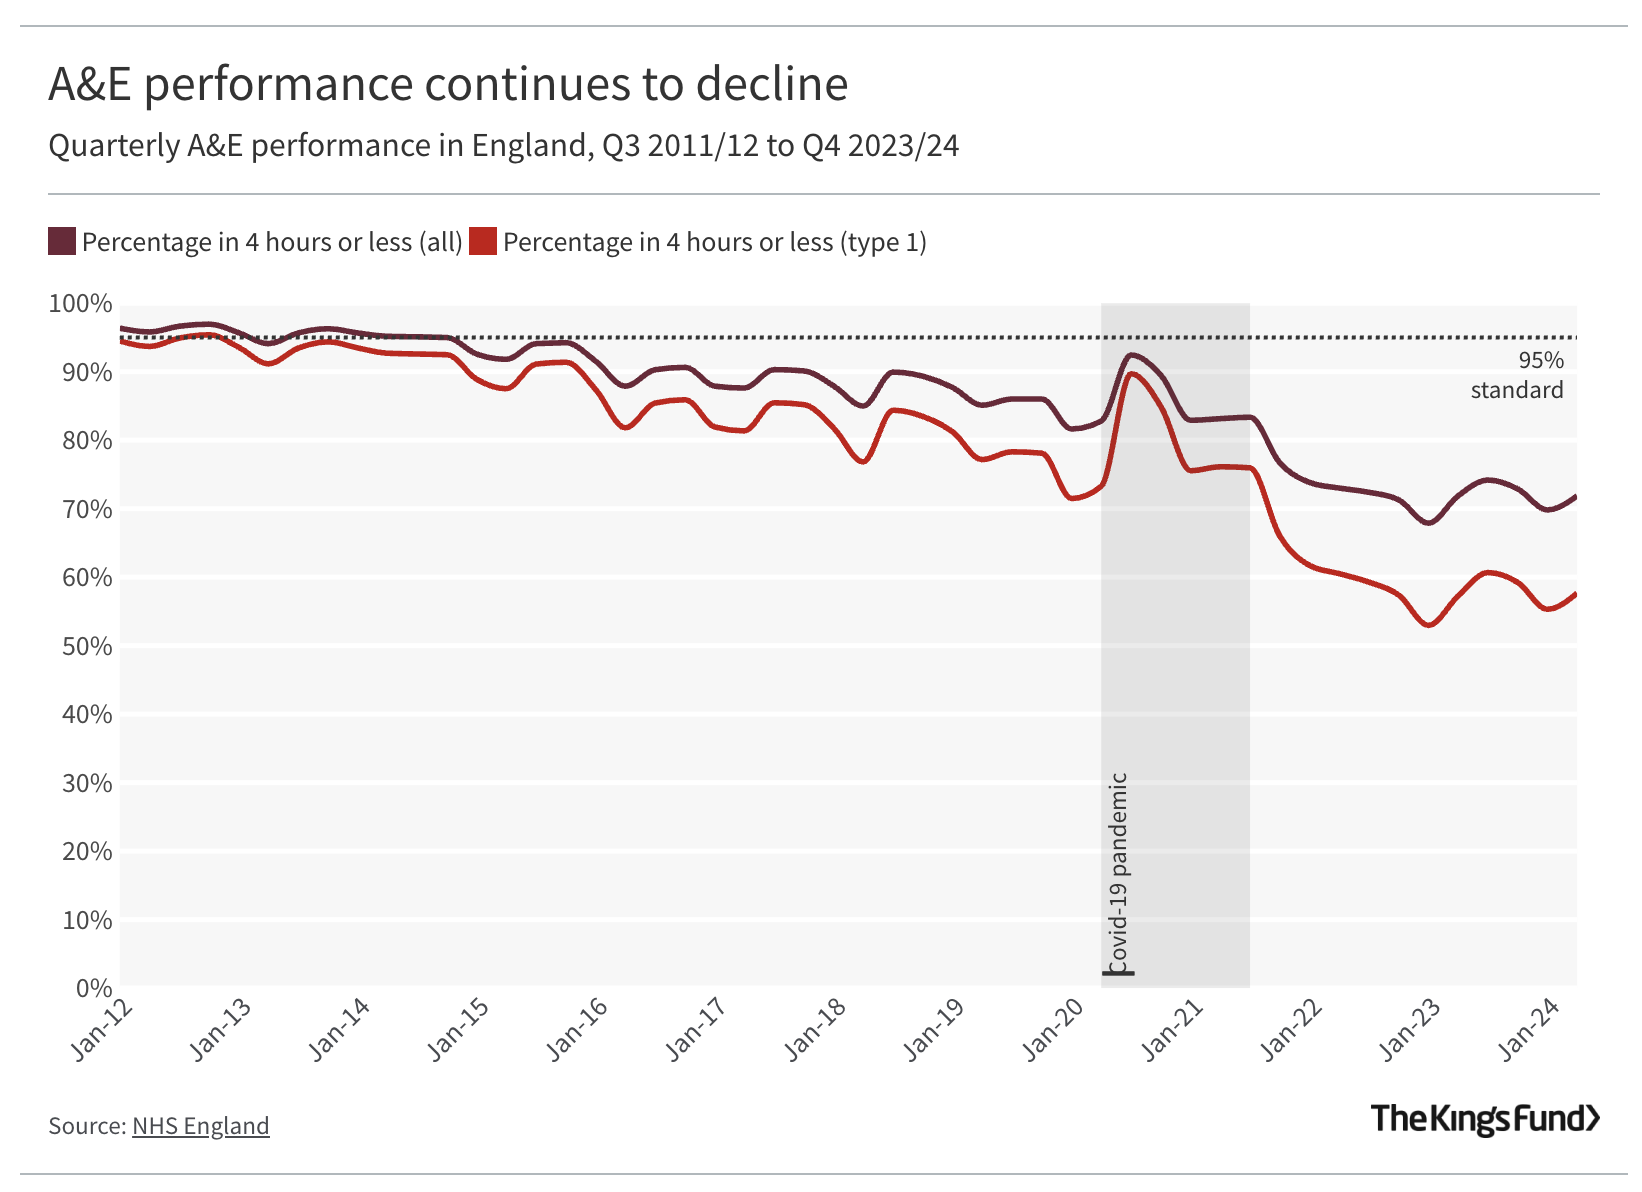

In [134]:
from IPython.display import Image
Image(filename='img/thumbnail_KingsFund_AE_performance.png')

`patientflow` offers an aspirational weighted Poisson model, that will calculate each patient's probability of being admitted within the prediction window, if targets are met. Targets are set using the parameters set in config.yaml, as shown below. 

In [135]:
from patientflow.load import load_config_file, set_file_paths, set_project_root
project_root = set_project_root()

_, _, _, config_path = set_file_paths(project_root, data_folder_name = 'data-public', verbose = False)
params = load_config_file(config_path)

x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]

print(f'The aspiration is that within {str(x1)} hours of arrival, {str(y1*100)}% of patients will have been admitted, and that witin {str(x2)} hours of arrival, {str(y2*100)}% of patients will have been admitted')

Inferred project root: /Users/zellaking/Repos/patientflow
The aspiration is that within 4.0 hours of arrival, 76.0% of patients will have been admitted, and that witin 12.0 hours of arrival, 99.0% of patients will have been admitted


The aspiration can be plotted as an inverted survival curve, as shown below. 

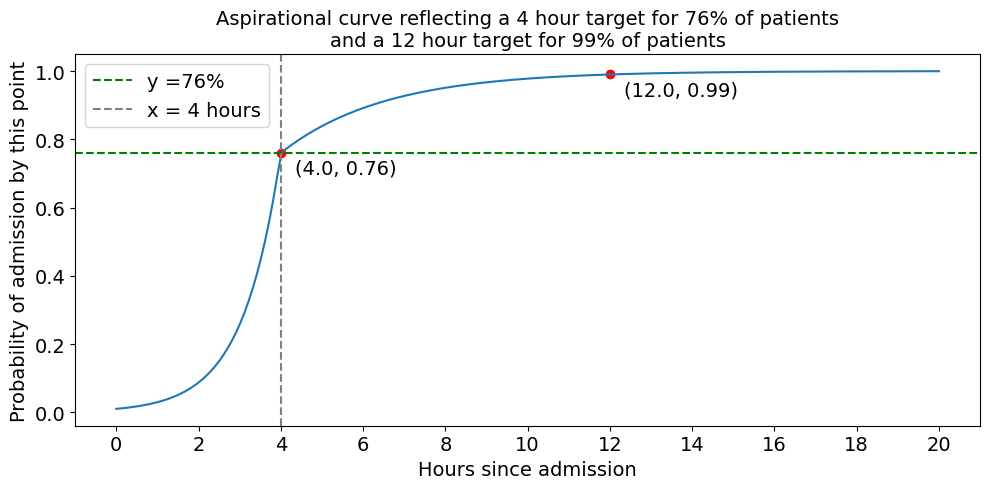

In [136]:
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)

plot_curve(
    title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients',
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    include_titles=True,
    annotate_points=True,
)


Below I demonstrate the use of a Weighted Poisson predictor. 

Its `fit()` method will, for each prediction time:

* filter the dataframe if a filtering criteria is given (more detail below)
* calculate arrival rates for a series of discrete time intervals (where the duration of each time interval is specified as `yta_time_interval` minutes) within a 24 hour period; `yta_time_interval` must divide evenly into a 24 hour period (ie be a factor of 24* 60)
* return the arrival rates for the intervals between the prediction time and the end of the prediction window in a dictionary; if the data is unfiltered it will use a generic key of 'unfiltered'; if the data is filtered, it will use the filters as keys

The `predict()` method will:

* retrieve the arrival rates saved for the prediction window
* for each discrete time interval, using the aspirational curve introduced above, and taking into account the time remaining before end of window, calculate a probability of admission in prediction window 
* weight the arrival rates for each time interval by this probability 
* generate a Poisson distribution for each time interval
* convolute the distributions to return a single distribution for admissions within the prediction window of patients yet-to-arrive

In [138]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor

train_visits_copy = train_visits.copy(deep=True)

yta_model =  WeightedPoissonPredictor(verbose=True)
num_days = (start_validation_set - start_training_set).days
if 'arrival_datetime' in train_visits_copy.columns:
    train_visits_copy.set_index('arrival_datetime', inplace=True)

yta_model.fit(train_visits_copy, 
              prediction_window=timedelta(hours=8), 
              yta_time_interval=timedelta(minutes=15), 
              prediction_times=prediction_times, 
              num_days=num_days)


Calculating time-varying arrival rates for data provided, which spans 45 unique dates
Weighted Poisson Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 8:00:00 after the time of prediction
and time interval of 0:15:00 within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


WeightedPoissonPredictor(filters={}, verbose=True)

Below we view the results of the fit method for the 12:00 prediction time. 

In [139]:
arrival_rates_by_time_interval = yta_model.weights['unfiltered'][(12,0)]['arrival_rates']
print(
    f'The calculated arrival rates for the first 10 discrete time intervals '
    f'for the 12:00 prediction time are: {[round(v, 3) for v in arrival_rates_by_time_interval[0:10]]}')

The calculated arrival rates for the first 10 discrete time intervals for the 12:00 prediction time are: [1.289, 1.067, 1.356, 1.2, 1.289, 1.356, 1.2, 1.178, 0.933, 0.889]


To use the weighted poisson for prediction, a `prediction_context` argument specifies the required prediction time and filtering. The aspirations for time to admission can be changed at any point. Here, I'm going to set the target at 95% within 4 hours. 

In [140]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time

prediction_context = {
    'unfiltered': {
        'prediction_time': tuple([12,0])
    }
}
x1, y1, x2, y2 = 4, 0.95, 12, 0.99
weighted_poisson_prediction = yta_model.predict(prediction_context, x1, y1, x2, y2)


The charts below compare the results of using this weighted predictor to generate a prediction for bed needed for patients yet-to-arrive, if the ED meets the 4-hour target for 95% of patients. The numbers are higher than the equivalent chart above. 

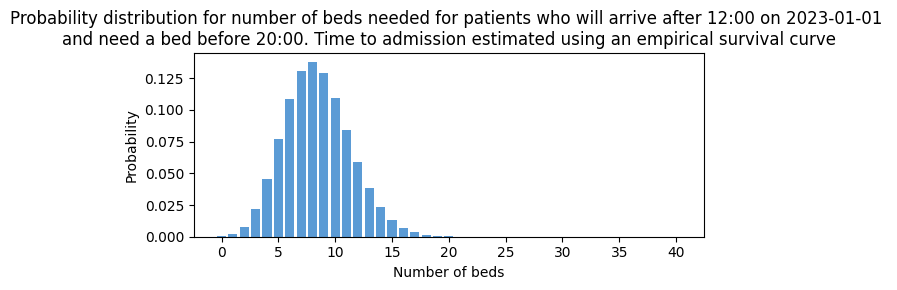

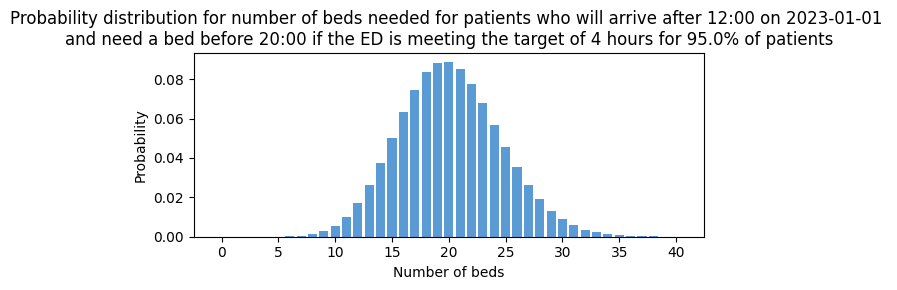

In [141]:
title = (
    f'Probability distribution for number of beds needed for patients '
    f'who will arrive after {format_prediction_time((12,0))} on {snapshot_dates[0]} '
    f'\nand need a bed before 20:00. Time to admission estimated using an empirical survival curve'
)
prob_dist_plot(combined_dist, title,  
    include_titles=True, truncate_at_beds=40)

title = (
    f'Probability distribution for number of beds needed for patients '
    f'who will arrive after {format_prediction_time((12,0))} on {snapshot_dates[0]} '
    f'\nand need a bed before 20:00 '
    f'if the ED is meeting the target of {int(x1)} hours for {y1*100}% of patients'
)
prob_dist_plot(weighted_poisson_prediction['unfiltered'], title,  
    include_titles=True,
    truncate_at_beds=40)

## Summary

Here I have demonstrated the use of `patientflow` to generate bed counts for groups of patients for which patient-level data is not yet available. 

If you have count data on past visits that approximate to a statistical distribution, preparing a  model to predict a bed count distribution is simple to do with standard libraries like scipy. You don't need `patientflow` functions for that. 

However there might be cases where the historical data don't reflect the desired performance of the ED, as in the example shown here. In that case, the users of your predictions might be more interested in understanding demand if their ED were performing per their aspirations. `patientflow`  provides functions that enable you to produce such predictions. 

## Postscript - how to evaluate bed counts based on survival curves

The survival curve plot function can be used with multiple datasets. This may be useful to check the alignment of training set and test set survival curves. If the ED has become slower to process patients, this difference may show up in a difference between survival curves. We encountered this issue in our own work, and showed how to mitigate it using a sliding window approach for the survival curve in our [Nature Digital Medicine paper](https://www.nature.com/articles/s41746-022-00649-y). The problem does not show up below because these curves are based on fake data. 

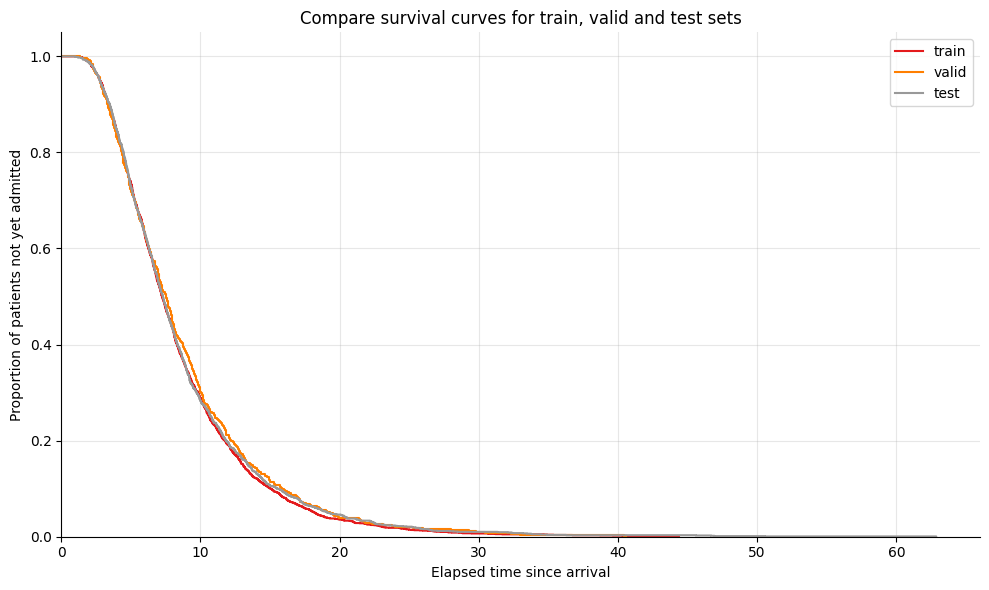

In [142]:
title = 'Compare survival curves for train, valid and test sets'
survival_df = plot_admission_time_survival_curve([train_visits, valid_visits, test_visits], 
                                                 labels=['train', 'valid', 'test'],
                                   start_time_col="arrival_datetime",
                                   end_time_col="admitted_to_ward_datetime",
                                   title=title,
                                   ylabel='Proportion of patients not yet admitted',
                                   xlabel='Elapsed time since arrival',
                                   return_df=False
)

The function below can be used to compare the predicted with the observed bed counts. This function will retrieve the observed counts and save them alongside their predicted distribution from the model.

In [143]:
from patientflow.aggregate import get_prob_dist_using_survival_predictor
from datetime import timedelta
from patientflow.load import get_model_key

prob_dist_dict_all = {}
test_set_dates = [dt for dt in snapshot_dates if dt >= start_test_set]

for prediction_time in prediction_times:
    model_key = get_model_key('yet_to_arrive', prediction_time)
    prob_dist_dict_all[model_key]= get_prob_dist_using_survival_predictor(
        snapshot_dates=test_set_dates,
        test_visits=test_visits,
        category='unfiltered',
        prediction_time=prediction_time,
        prediction_window=timedelta(minutes=8*60),
        start_time_col='arrival_datetime',
        end_time_col='admitted_to_ward_datetime',
        model=yta_model_empirical,
        verbose=False,
    )

The result can be plotted using the same functions. The model appears as a series of vertical lines because the EmpiricalSurvivalPredictor is very crude; it is trained only on a time of day. We have included it here as a placeholder, to show how modelling of yet-to-arrive patients using past data on time to admission could be done, and how it could be evaluated. You could modify the function to include a weekday/weekend variable, or replace it with a different approach based on moving averages (such as ARIMA).  


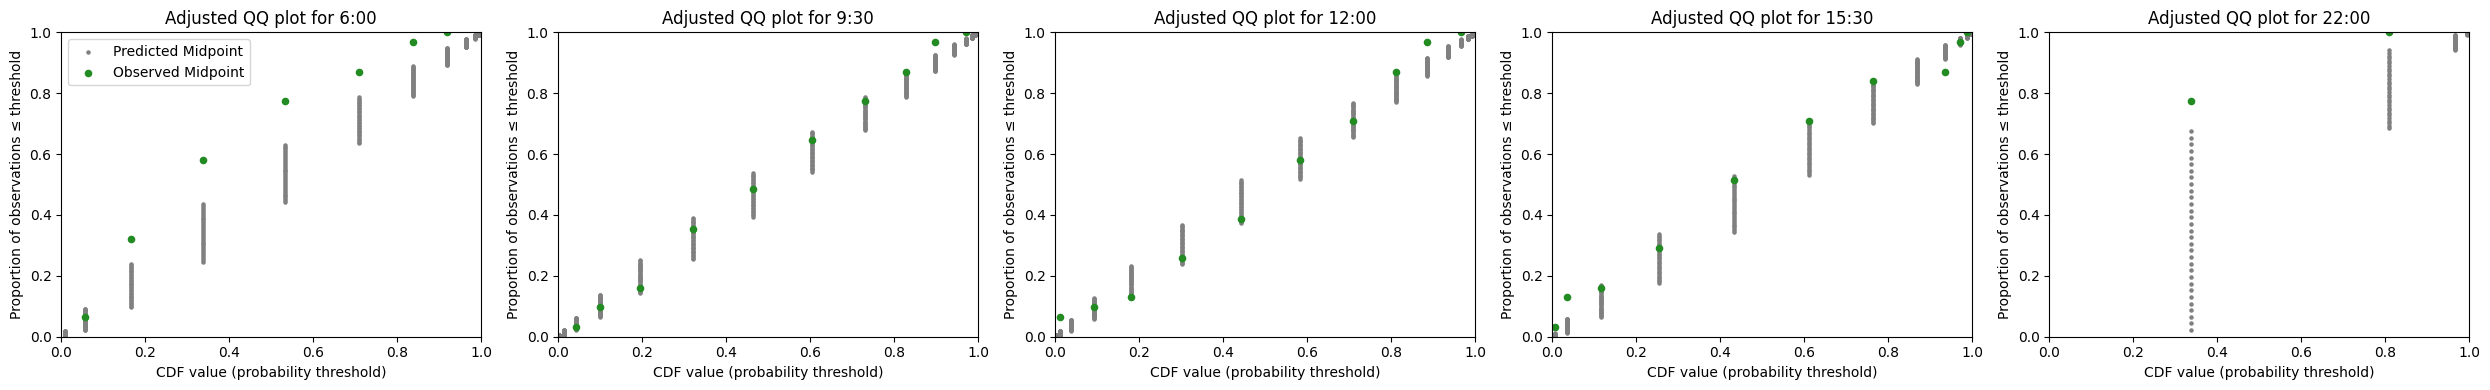

In [144]:
from patientflow.viz.adjusted_qq_plot import adjusted_qq_plot

adjusted_qq_plot(prediction_times,
                 prob_dist_dict_all,
                 model_name='yet_to_arrive',
                 plot_all_bounds=False)